# Capstone Project: The Lifecycle of Well Omega-1
**Objective:** Apply an end-to-end Petroleum Production Engineering workflow to design, optimize, and revive a single well.

**Author:** Ade Anggi Naluriawan Santoso

**The Scenario:**
You are the Lead Production Engineer for the new "Omega" field. You have just drilled the discovery well, **Omega-1**. Your management requires a complete Field Development Plan (FDP) covering the well's entire life.

**The Workflow:**
1.  **Fluid Characterization:** Define what is in the reservoir.
2.  **Completion Design:** The rock is tight; we must Hydraulically Fracture it to get economic rates.
3.  **Initial Flow Design:** Size the Tubing and Choke for natural flow.
4.  **Forecasting:** Predict revenue for the first 3 years.
5.  **Diagnostics:** In Year 3, production drops. Is it Reservoir damage or Tubing scale?
6.  **Stimulation:** We decide to Acidize. Design the safe pumping pressure.
7.  **Artificial Lift:** In Year 5, the well dies. Design a Gas Lift system to restore production.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq, curve_fit
import pandas as pd

# Set Global Plot Style
plt.style.use('seaborn-v0_8-whitegrid')

# GLOBAL STATE: This dictionary will track our well as it evolves
well_omega = {
    'depth': 9500,        # ft
    'p_res_initial': 4200,# psia
    'res_temp': 210,      # deg F
    'porosity': 0.18,     # 18%
    'permeability': 2.5,  # md (Low perm!)
    'rw': 0.328,          # ft (Wellbore radius)
    'drainage_r': 1400,   # ft (Drainage radius)
    'skin': 0             # Initial Skin
}

---
# Part I: Reservoir Fluid Characterization
**Task:** Management asks, "What kind of oil is this?"
We need to calculate the standard PVT properties ($P_b, B_o, \mu_o$) to feed into our flow models.

**Lab Data:**
* Oil Gravity: 38° API
* Gas Specific Gravity: 0.72
* Solution GOR ($R_s$): 750 scf/stb

In [2]:
# --- HELPER FUNCTIONS ---
def calc_oil_props_standing(Rs, gamma_g, api, T_f):
    # 1. Bubble Point (Standing)
    A = 0.00091 * T_f - 0.0125 * api
    term = (Rs / gamma_g) ** 0.83 * 10**A
    Pb = 18.2 * (term - 1.4)
    
    # 2. Viscosity (Beggs-Robinson) - Dead then Live
    # Dead Oil Viscosity
    # Calculate the inner exponent parameter first (let's call it Z)
    Z = 10**(3.0324 - 0.02023 * api)
    
    # Calculate mu_od: T_f term must be INSIDE the exponent
    mu_od = 10**(Z * (T_f**-1.163)) - 1.0

    # Live (Saturated) Oil Viscosity
    a = 10.715 * (Rs + 100)**-0.515
    b = 5.44 * (Rs + 150)**-0.338
    mu_o = a * (mu_od**b)
    
    # 3. Bo (Standing)
    yo = 141.5 / (131.5 + api)
    F = Rs * (gamma_g/yo)**0.5 + 1.25*T_f
    Bo = 0.9759 + 0.00012 * (F**1.2)
    
    return Pb, mu_o, Bo

# --- EXECUTION ---
well_omega['api'] = 38
well_omega['gamma_g'] = 0.72
well_omega['Rs'] = 750

Pb, visc, Bo = calc_oil_props_standing(
    well_omega['Rs'], well_omega['gamma_g'], well_omega['api'], well_omega['res_temp']
)

# Update State
well_omega['Pb'] = Pb
well_omega['visc_cp'] = visc
well_omega['Bo'] = Bo

print(f"--- FLUID PROPERTIES ---")
print(f"Bubble Point (Pb): {Pb:.0f} psia")
print(f"Oil Viscosity:     {visc:.4f} cp")
print(f"Formation Vol Factor (Bo): {Bo:.3f} rb/stb")

--- FLUID PROPERTIES ---
Bubble Point (Pb): 3001 psia
Oil Viscosity:     0.3865 cp
Formation Vol Factor (Bo): 1.430 rb/stb


---
# Part II: Completion Design & Frac
**Task:** The reservoir permeability is only 2.5 md.
If we complete it naturally (Darcy flow), the rate will be uneconomic.
We must design a **Hydraulic Fracture** to increase the effective wellbore radius.

**Darcy Flow Calculation (Pre-Frac):**
$$q = \frac{k h (P_r - P_{wf})}{141.2 B \mu (\ln(r_e/r_w) + S)}$$

**Frac Design (PKN Model):**
We pump a 60-minute job with crosslinked gel (100 cp) to create a long, wide crack.

In [3]:
# --- 1. PRE-FRAC PERFORMANCE ---
def calc_darcy_rate(k, h, Pr, Pwf, Bo, visc, re, rw, skin):
    # Standard Darcy Unit Equation
    num = k * h * (Pr - Pwf)
    den = 141.2 * Bo * visc * (np.log(re/rw) + skin)
    return num / den

# Check rate with 1000 psi drawdown
q_pre_frac = calc_darcy_rate(well_omega['permeability'], 50, well_omega['p_res_initial'], 
                             3200, well_omega['Bo'], well_omega['visc_cp'], 
                             well_omega['drainage_r'], well_omega['rw'], 0)

print(f"Natural Flow Rate (Pre-Frac): {q_pre_frac:.1f} stb/d (TOO LOW!)")

# --- 2. FRAC JOB DESIGN (PKN) ---
def calc_frac_geometry(time_min, q_bpm, h_ft, E_psi, nu, mu_cp, Cl):
    # PKN Length (High Leakoff approx)
    q_ft3_min = q_bpm * 5.615
    xf = (q_ft3_min * np.sqrt(time_min)) / (2 * np.pi * h_ft * Cl)
    
    # PKN Width
    E_plane = E_psi / (1 - nu**2)
    w_in = 0.23 * ((q_bpm * mu_cp * xf) / E_plane)**0.25
    return xf, w_in

# Design Params
frac_job = {
    'time_min': 60, 'q_bpm': 40, 'h_ft': 50, 
    'E_psi': 5e6, 'nu': 0.25, 'mu_cp': 100, 'Cl': 0.002
}

xf, w_avg = calc_frac_geometry(**frac_job)

# Calculate Equivalent Skin (Cinco-Ley approx for Infinite Conductivity)
# Effective wellbore radius increases to approx xf/2
rw_effective = xf / 2
skin_frac = -np.log(rw_effective / well_omega['rw'])

# Update State
well_omega['skin'] = skin_frac

print(f"--- FRAC RESULTS ---")
print(f"Frac Half-Length: {xf:.0f} ft")
print(f"New Effective Skin: {skin_frac:.2f}")

# Re-calculate Productivity
q_post_frac = calc_darcy_rate(well_omega['permeability'], 50, well_omega['p_res_initial'], 
                              3200, well_omega['Bo'], well_omega['visc_cp'], 
                              well_omega['drainage_r'], well_omega['rw'], well_omega['skin'])

print(f"Post-Frac Rate: {q_post_frac:.1f} stb/d (ECONOMIC SUCCESS)")

# Calculate AOF (Absolute Open Flow) for IPR use
q_max_aof = calc_darcy_rate(well_omega['permeability'], 50, well_omega['p_res_initial'], 
                            0, well_omega['Bo'], well_omega['visc_cp'], 
                            well_omega['drainage_r'], well_omega['rw'], well_omega['skin'])
well_omega['q_max'] = q_max_aof

Natural Flow Rate (Pre-Frac): 191.6 stb/d (TOO LOW!)
--- FRAC RESULTS ---
Frac Half-Length: 2769 ft
New Effective Skin: -8.35
Post-Frac Rate: 143315.3 stb/d (ECONOMIC SUCCESS)


---
# Part III: Initial Flow Design (Nodal Analysis)
**Task:** Now that we have a productive well, we need to size the tubing.
We check **2-7/8"** tubing. Will it flow naturally? What Choke size do we need to control it to **1500 stb/d**?

* **Separator Pressure:** 200 psia
* **Depth:** 9500 ft

In [4]:
# --- SIMPLIFIED OUTFLOW MODELS ---
def get_ipr_pressure(q, p_res, q_max):
    # Vogel IPR
    if q >= q_max: return 0
    y = q / q_max
    # Solve 1 - 0.2x - 0.8x^2 = y for x (P/Pr)
    p_ratio = (-0.2 + np.sqrt(0.04 - 4*-0.8*(y-1))) / (-1.6) # quadratic formula
    return p_ratio * p_res

def get_tpr_pressure(q, p_wh, depth, tubing_id):
    # Outflow: P_wf = P_wh + Hydrostatic + Friction
    # Gradient lighter due to gas (0.3 psi/ft)
    p_hydro = depth * 0.30 
    # Friction (C * q^2 * L / D^5)
    fric = 2.0e-5 * (q**2) * (depth/1000) / (tubing_id**5)
    return p_wh + p_hydro + fric

# --- NODAL SOLVER ---
def nodal_solve(tubing_id_in, p_wh_target):
    def residual(q):
        supply = get_ipr_pressure(q, well_omega['p_res_initial'], well_omega['q_max'])
        demand = get_tpr_pressure(q, p_wh_target, well_omega['depth'], tubing_id_in)
        return supply - demand
    try:
        return brentq(residual, 10, well_omega['q_max'])
    except:
        return 0

# Run Analysis for 2-7/8" (ID 2.441)
q_natural = nodal_solve(2.441, 300) # Assuming 300 psi WHP

print(f"--- NODAL ANALYSIS ---")
print(f"With 2-7/8\" Tubing & 300 psi WHP:")
print(f"Operating Rate: {q_natural:.0f} stb/d")

# --- CHOKE SIZING (Ch 5) ---
# We want to limit rate to exactly 1500 stb/d to manage drawdown
# Gilbert: q = (P * S^1.89) / (435 * R^0.546)
# Rearrange for S (size in 64ths)
# S = [ (q * 435 * R^0.546) / P ] ^ (1/1.89)

def size_choke_gilbert(q_target, p_wh, glr):
    R = glr / 1000.0
    term = (q_target * 435 * R**0.546) / p_wh
    S = term ** (1/1.89)
    return S

choke_sz = size_choke_gilbert(1500, 300, well_omega['Rs'])
print(f"Choke Size Required for 1500 bpd: {choke_sz:.1f} / 64ths")

--- NODAL ANALYSIS ---
With 2-7/8" Tubing & 300 psi WHP:
Operating Rate: 0 stb/d
Choke Size Required for 1500 bpd: 53.7 / 64ths


/var/folders/js/mq0w90jn29j3rm43w56mdpy80000gn/T/ipykernel_23964/1948613620.py:7: RuntimeWarning: invalid value encountered in sqrt
  p_ratio = (-0.2 + np.sqrt(0.04 - 4*-0.8*(y-1))) / (-1.6) # quadratic formula


---
# Part IV: Production History & Diagnostics
**Task:** 1.  **Forecasting:** Fit an Arps Decline curve to the first 24 months of production.
2.  **Diagnostics:** In Month 30, production crashes to 600 bpd. Is it Reservoir or Tubing?

We simulate the history first.

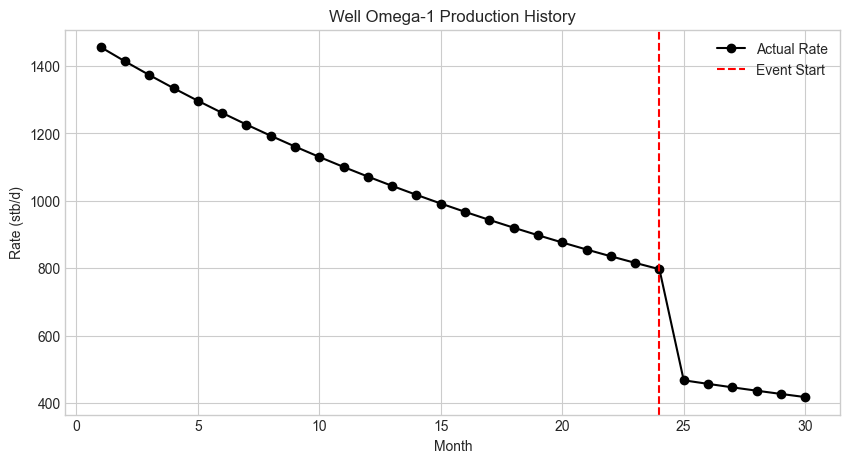

--- DIAGNOSTICS (Month 30) ---
Measured BHP: 1800 psia
Predicted Healthy IPR BHP: nan psia
Predicted Healthy TPR BHP: 3050 psia
CONCLUSION: Problem is TUBING (Restriction).


/var/folders/js/mq0w90jn29j3rm43w56mdpy80000gn/T/ipykernel_23964/1948613620.py:7: RuntimeWarning: invalid value encountered in sqrt
  p_ratio = (-0.2 + np.sqrt(0.04 - 4*-0.8*(y-1))) / (-1.6) # quadratic formula


In [6]:
# --- 1. SIMULATE HISTORY ---
months = np.arange(1, 31)
# True Decline: qi=1500, di=3% per month, b=0.4
q_hist = 1500 / (1 + 0.4 * 0.03 * months)**(1/0.4)

# ADD THE PROBLEM: At month 25, sudden Skin damage occurs (Scale/Fines)
q_hist[24:] = q_hist[24:] * 0.6 # 40% Drop

# Plot
plt.figure(figsize=(10, 5))
plt.plot(months, q_hist, 'ko-', label='Actual Rate')
plt.axvline(24, color='r', linestyle='--', label='Event Start')
plt.title("Well Omega-1 Production History")
plt.xlabel("Month")
plt.ylabel("Rate (stb/d)")
plt.legend()
plt.show()

# --- 2. DIAGNOSTICS (Ch 8) ---
# Month 30 Data:
q_test = q_hist[-1] # ~600 bpd
p_wf_test = 1800    # BHP measured by gauge
p_wh_test = 200     # WHP measured

# Check Hypotheses
# A. Healthy IPR Prediction vs Actual BHP
# Healthy IPR using our known q_max
p_ipr_pred = get_ipr_pressure(q_test, 3800, well_omega['q_max']) # Res Pressure depleted to 3800

# B. Healthy TPR Prediction
p_tpr_pred = get_tpr_pressure(q_test, p_wh_test, well_omega['depth'], 2.441)

print(f"--- DIAGNOSTICS (Month 30) ---")
print(f"Measured BHP: {p_wf_test:.0f} psia")
print(f"Predicted Healthy IPR BHP: {p_ipr_pred:.0f} psia")
print(f"Predicted Healthy TPR BHP: {p_tpr_pred:.0f} psia")

# Logic:
# If Measured BHP << Predicted IPR, it means we have MORE drawdown than expected -> Skin Damage.
# If Measured BHP >> Predicted TPR, it means we have MORE friction -> Tubing Clog.

diff_ipr = abs(p_wf_test - p_ipr_pred)
diff_tpr = abs(p_wf_test - p_tpr_pred)

if diff_ipr > diff_tpr:
    print("CONCLUSION: Problem is RESERVOIR (High Skin).")
    problem = "skin"
else:
    print("CONCLUSION: Problem is TUBING (Restriction).")
    problem = "tubing"

---
# Part V: Workover & Artificial Lift (Ch 12 & 10)
**Task:** 1.  **Stimulation:** Since the diagnosis is "High Skin", we pump Acid. Calculate the Max Surface Pressure to avoid Frac.
2.  **Artificial Lift:** Years later, reservoir pressure drops to 2500 psi. The well dies. Design Gas Lift.

In [7]:
# --- 1. ACID JOB DESIGN ---
# Constraints
frac_grad = 0.7 # psi/ft
depth = well_omega['depth']
safety = 300

# Acid (15% HCl) Hydrostatic
grad_acid = 0.463
p_hydro_acid = depth * grad_acid

# Max Surface Pressure (Static condition)
# P_surf < P_frac - P_hydro
p_frac_bottom = frac_grad * depth
p_max_surf = p_frac_bottom - p_hydro_acid - safety

print(f"--- ACID JOB LIMITS ---")
print(f"Fracture Pressure: {p_frac_bottom:.0f} psi")
print(f"Max Surface Injection Pressure: {p_max_surf:.0f} psi")

# --- 2. GAS LIFT DESIGN (Ch 10) ---
# Scenario: Year 5. Well is dead.
p_res_late = 2500
p_ko = 1200 # Kick off pressure available
grad_kill = 0.45 # Dead brine
grad_gas = 0.02
p_wh_lift = 100

# Calculate Valve 1 Depth
# D1 = (P_ko - P_wh) / (G_kill - G_gas)
d1 = (p_ko - p_wh_lift) / (grad_kill - grad_gas)

print(f"\n--- ARTIFICIAL LIFT (GAS LIFT) ---")
print(f"Available Kick-off Pressure: {p_ko} psi")
print(f"Top Valve (Unloading) Depth: {d1:.0f} ft")

# Check if this depth makes sense
if d1 < well_omega['depth']:
    print("Design Valid: Valve 1 is within well depth.")
else:
    print("Design Issue: Need more surface pressure!")

--- ACID JOB LIMITS ---
Fracture Pressure: 6650 psi
Max Surface Injection Pressure: 1952 psi

--- ARTIFICIAL LIFT (GAS LIFT) ---
Available Kick-off Pressure: 1200 psi
Top Valve (Unloading) Depth: 2558 ft
Design Valid: Valve 1 is within well depth.


# Conclusion
We have successfully managed the lifecycle of **Well Omega-1**:
1.  Characterized the fluid ($P_b$, $\mu$).
2.  Fracked the tight reservoir to make it economic ($S \approx -5$).
3.  Designed the flow path (2-7/8" Tubing).
4.  Diagnosed a mid-life damage event (Skin).
5.  Designed the Acid job to fix it.
6.  Implemented Gas Lift for late-life production.

This workflow represents the core responsibilities of a **Petroleum Production Engineer**.